# Bring Packages

In [1]:
import numpy as np
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt

# Load Data

In [2]:
# Load data
print("Loading training data...")
X_train = np.load("..Data//data_train.npy").astype(int)
print("Training data loaded.")
# shape: (num_documents, num_terms)
print("Loading training labels...")
y_train = np.loadtxt('..Data//label_train.csv',skiprows=1,delimiter=',').astype(int)  # shape: (num_documents,)
print("Training labels loaded.")
print("Loading test data...")
X_test = np.load("..Data//data_test.npy").astype(int)  # shape: (num_test_documents, num_terms)
print("Test data loaded.")
print("Loading vocabulary...")
vocab_data = np.load("..Data//vocab_map.npy", allow_pickle=True)
print("Vocab data loaded.")

# Check dimensions
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Vocab data shape: {vocab_data.shape}")



Loading training data...


FileNotFoundError: [Errno 2] No such file or directory: '..Data//data_train.npy'

In [36]:
vocab_data.shape

(26354,)

In [37]:
x_raw = X_train
y_raw = y_train[:,1]

In [38]:
def testdf(df):
    if isinstance(df, pd.DataFrame):
        print("The object is a DataFrame.")
    else:
        print("The object is not a DataFrame.")

def test_if_list(obj):
    if isinstance(obj, list):
        print("The object is a list.")
    else:
        print("The object is not a list.")

def test_if_tuple(obj):
    if isinstance(obj, tuple):
        print("The object is a tuple.")
    else:
        print("The object is not a tuple.")

def test_if_array(obj):
    if isinstance(obj, np.ndarray):
        print("The object is a numpy array.")
    else:
        print("The object is not a numpy array.")

# Model

In [39]:
print(y_train)
print(y_raw)

[[   0    0]
 [   1    0]
 [   2    0]
 ...
 [9419    0]
 [9420    0]
 [9421    0]]
[0 0 0 ... 0 0 0]


# Data Visualization

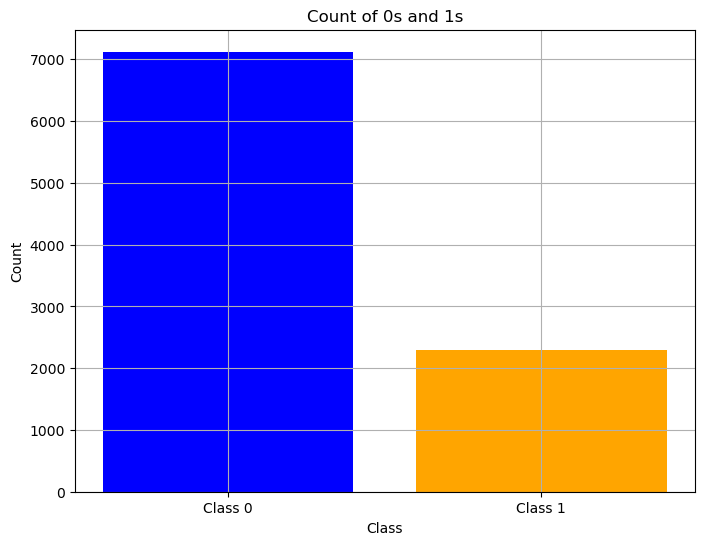

In [40]:
# Extract the class labels from the second column of y_train
class_labels = y_raw

# Count the occurrences of class 0 and class 1
unique, counts = np.unique(class_labels, return_counts=True)
count_dict = dict(zip(unique, counts))

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(count_dict.keys(), count_dict.values(), color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of 0s and 1s')
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.grid(True)
plt.show()

In [41]:
# Calculate the difference and ratio of counts
count_diff = abs(count_dict[0] - count_dict[1])
count_ratio = count_dict[0] / count_dict[1] if count_dict[1] != 0 else float('inf')

# Print the results
print(f"Difference in counts: {count_diff}")
print(f"Ratio of counts: {count_ratio:.2f}")

Difference in counts: 4826
Ratio of counts: 3.10


In [42]:
def print_class_percentages(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    percentages = {cls: (count / total) * 100 for cls, count in zip(unique, counts)}
    
    print(f"Class percentages for {dataset_name}:")
    for cls, percentage in percentages.items():
        print(f"Class {cls}: {percentage:.2f}%")

# Print class percentages for training and test datasets
print_class_percentages(class_labels, "Training Dataset")


Class percentages for Training Dataset:
Class 0: 75.61%
Class 1: 24.39%


In [43]:
print(unique, counts)

[0 1] [7124 2298]


## See on average how often does a word appear in text

In [44]:
## See on average how often does a word appear in text

In [47]:
ind_class0 = (y_raw==1).nonzero()[0]
print(ind_class0)
ind_class1 = (y_raw==0).nonzero()[0]
print(ind_class1)

[   4    8    9 ... 9410 9412 9418]
[   0    1    2 ... 9419 9420 9421]


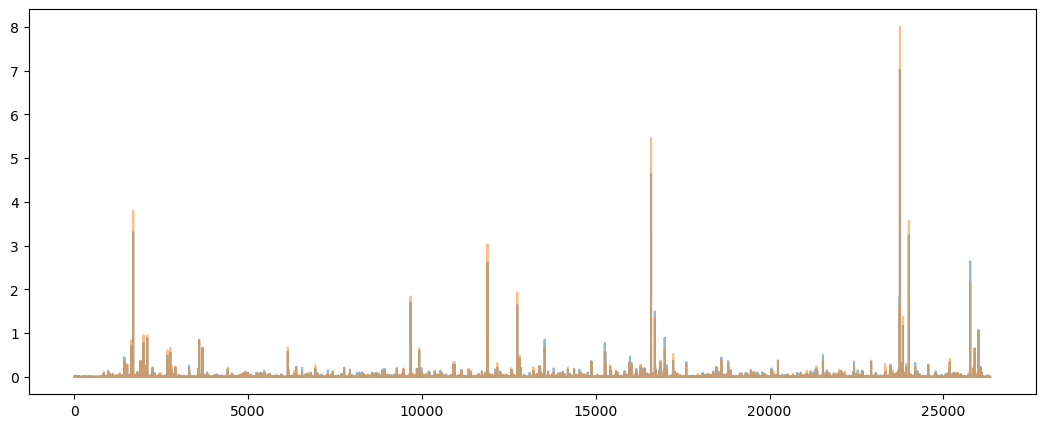

In [48]:
plt.figure(figsize=(13,5))
plt.plot(X_train[ind_class0,:].mean(axis=0),alpha=0.5)
plt.plot(X_train[ind_class1,:].mean(axis=0),alpha=0.5)
# plt.semilogy()
# plt.ylim(0.1,2)

In [51]:
# Calculate the mean appearance of each word for each class
mean_appearance_class_0 = x_raw[y_raw == 0].mean(axis=0)
mean_appearance_class_1 = x_raw[y_raw == 1].mean(axis=0)

# Compute the absolute difference in mean appearance between the two classes
mean_difference = np.abs(mean_appearance_class_0 - mean_appearance_class_1)

# Identify the words with the largest differences
largest_diff_indices = np.argsort(mean_difference)[::-1]  # Sort indices in descending order of difference

top_n = 30  # Number of top words to display
top_words = [vocab_data[i] for i in largest_diff_indices[:top_n]]
print(top_words)


['the', 'of', 'and', 'we', 'in', 'to', 'is', 'our', 'that', 'models', 'this', 'model', 'learning', 'neural', 'system', 'are', 'on', 'paper', 'show', 'for', 'based', 'used', 'systems', 'an', 'art', 'be', 'matrix', 'convex', 'information', 'tasks']


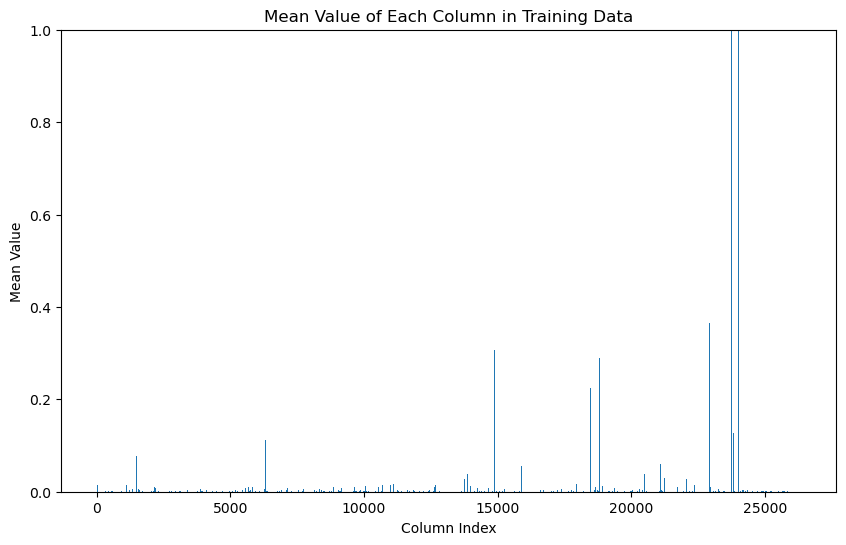

In [58]:
column_means = np.mean(x_raw, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_means)), column_means)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.ylim(0, 1)
plt.title('Mean Value of Each Column in Training Data')
plt.show()

In [59]:
column_means

array([0.00021227, 0.00870304, 0.00010613, ..., 0.00021227, 0.00021227,
       0.00159202])

## Identify the means of appearance of words when class 1 vs when class 0 and finding the words with the largest difference of appearances

In [24]:
X_train = X_resampled
y_train = y_resampled

In [25]:
# Calculate the mean appearance of each word for each class
mean_appearance_class_0 = X_train[y_train == 0].mean(axis=0)
mean_appearance_class_1 = X_train[y_train == 1].mean(axis=0)

# Compute the absolute difference in mean appearance between the two classes
mean_difference = np.abs(mean_appearance_class_0 - mean_appearance_class_1)

# Identify the words with the largest differences
largest_diff_indices = np.argsort(mean_difference)[::-1]  # Sort indices in descending order of difference

top_n = 30  # Number of top words to display
top_words = [vocab_data[i] for i in largest_diff_indices[:top_n]]
print(top_words)


['the', 'of', 'we', 'and', 'in', 'to', 'is', 'our', 'models', 'that', 'this', 'model', 'learning', 'system', 'neural', 'are', 'paper', 'on', 'for', 'based', 'systems', 'used', 'show', 'matrix', 'an', 'art', 'tasks', 'be', 'convex', 'state']


In [26]:
mean_difference

array([0.00028074, 0.00407075, 0.00014037, ..., 0.00028074, 0.00028074,
       0.00210556])

In [27]:
#Remove the useless data
# Calculate the mean of each column
column_means = X_train.mean(axis=0)

# Identify columns where the mean is zero
columns_to_drop = np.where(column_means == 0)[0]

# Drop these columns from the dataset
X_train_zero_dropped = np.delete(X_train, columns_to_drop, axis=1)



In [28]:
#log transform the data

x_log = np.log(X_train_zero_dropped+1)

In [29]:
x_raw.shape

(9422, 26354)

In [30]:
y_raw.shape

(9422,)

In [31]:
len(column_means)

26354

In [32]:
column_means = np.mean(x_log, axis=0)
means = np.mean(x_log, axis=1)
std = column_means.std()
means


array([0.00206832, 0.00306722, 0.00169472, ..., 0.00339478, 0.00288074,
       0.00417394])

In [33]:
np.mean(column_means)

0.002888312271943901

In [34]:
np.std(column_means)

0.028982138500157066

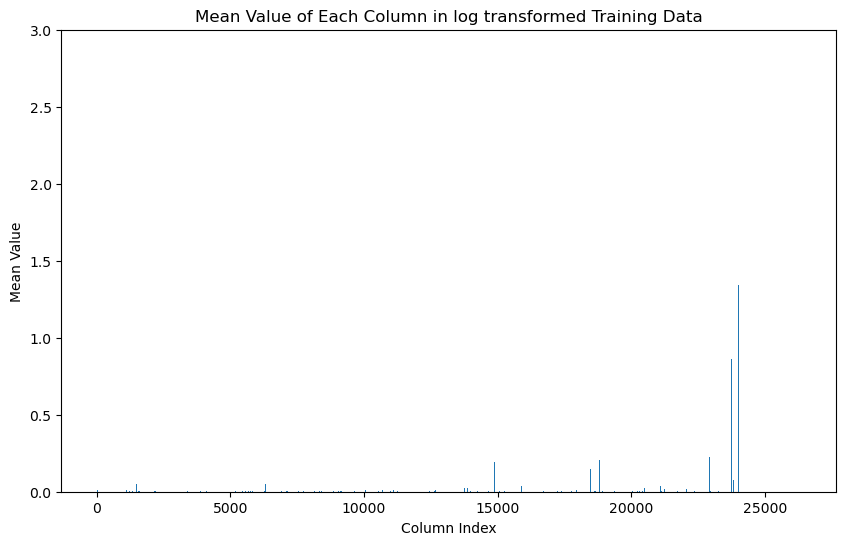

In [35]:
column_means = np.mean(x_log, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_means)), column_means)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.ylim(0, 3)
plt.title('Mean Value of Each Column in log transformed Training Data')
plt.show()

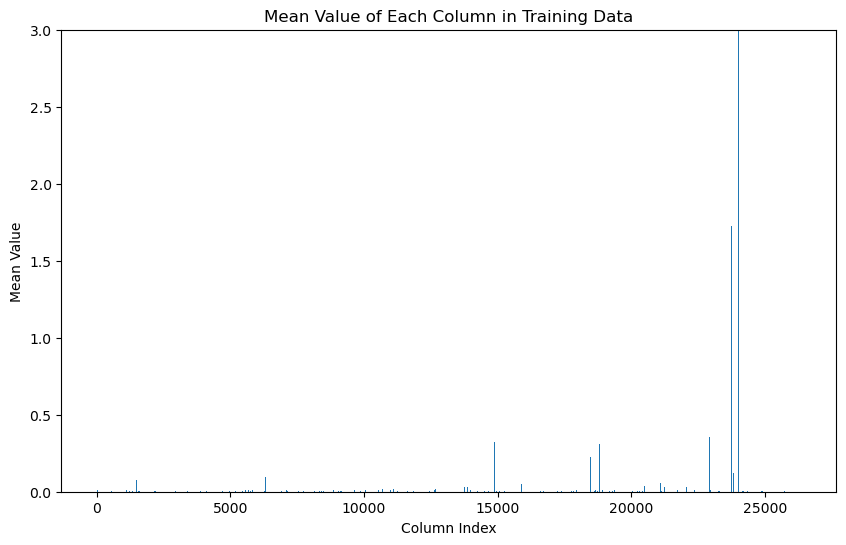

In [36]:
column_means = np.mean(X_train_zero_dropped, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_means)), column_means)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.ylim(0, 3)
plt.title('Mean Value of Each Column in Training Data')
plt.show()

In [ ]:
## Use Variance Threshold to remove low mean features

In [ ]:
from sklearn.feature_selection import VarianceThreshold

## Stop words removal

In [48]:
# Define a list of stop words
stop_words = ['a', 'an', 'the', 'and', 'or', 'but', 'if', 'while', 'with', 'without', 'of', 'at', 'by', 'for', 'to', 'in', 'on', 'from', 'up', 'down', 'out', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

# Identify the indices of the stop words in the vocabulary
stop_word_indices = [i for i, word in enumerate(vocab_data) if word in stop_words]

print(stop_word_indices)

[1293, 1466, 1634, 1691, 1811, 2246, 3299, 3571, 3590, 3686, 7452, 7487, 7761, 9341, 9674, 9921, 10008, 11072, 11341, 11639, 11884, 13002, 15415, 15442, 16141, 16262, 16291, 16335, 16591, 16701, 16703, 16717, 16865, 16972, 16991, 17049, 17136, 20791, 21536, 21929, 22003, 22924, 23744, 23753, 23774, 23796, 24009, 24051, 24780, 25114, 25415, 25891, 25894, 25911, 25926, 25974, 26016, 26021]


## Data manipulation and feature engineering

x_raw shape: (9422, 26354)
y_raw shape: (9422,)
X_test shape: (2356, 26354)
Shape after removing stop words: (9422, 26296)
Shape after removing stop words from test data: (2356, 26296)
Shape after variance thresholding: (9422, 2379)
Shape after variance thresholding on test data: (2356, 2379)
Shape after TF-IDF transformation: (9422, 2379)
Shape after TF-IDF transformation on test data: (2356, 2379)
Shape after clipping: (9422, 2379)
Shape after clipping on test data: (2356, 2379)
Shape after chi-square feature selection: (9422, 1000)
Shape after chi-square feature selection on test data: (2356, 1000)
Original class distribution: Counter({0: 7124, 1: 2298})
Resampled class distribution: Counter({0: 7124, 1: 7124})
Original x_raw shape: (9422, 26354)
Filtered x_raw shape: (9422, 2379)
TF-IDF x_raw shape: (9422, 2379)
Clipped x_raw shape: (9422, 2379)
Chi-Square x_raw shape: (9422, 1000)
Resampled x_raw shape: (14248, 1000)
Original y_raw shape: (9422,)
Resampled y_raw shape: (14248,)


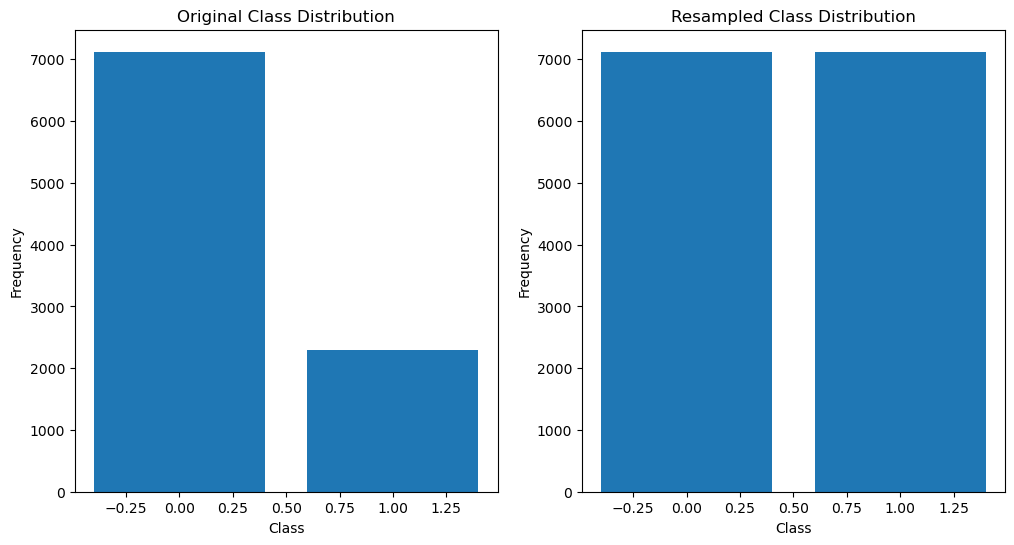

In [72]:

# Check the shapes of x_raw and y_raw
print(f"x_raw shape: {x_raw.shape}")
print(f"y_raw shape: {y_raw.shape}")
print(f"X_test shape: {X_test.shape}")

# Ensure consistent lengths
if x_raw.shape[0] != y_raw.shape[0]:
    raise ValueError("x_raw and y_raw must have the same number of samples")

# Define a list of stop words
stop_words = ['a', 'an', 'the', 'and', 'or', 'but', 'if', 'while', 'with', 'without', 'of', 'at', 'by', 'for', 'to', 'in', 'on', 'from', 'up', 'down', 'out', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

# Identify the indices of the stop words in the vocabulary
stop_word_indices = [i for i, word in enumerate(vocab_data) if word in stop_words]

# Remove the columns corresponding to the stop words from x_raw and X_test
X_no_stop_words = np.delete(x_raw, stop_word_indices, axis=1)
X_test_no_stop_words = np.delete(X_test, stop_word_indices, axis=1)

# Filter the vocabulary
filtered_vocab = np.delete(vocab_data, stop_word_indices)

# Check the shape after removing stop words
print(f"Shape after removing stop words: {X_no_stop_words.shape}")
print(f"Shape after removing stop words from test data: {X_test_no_stop_words.shape}")

# Apply Variance Thresholding to remove low-variance columns
threshold = 0.01  # You can adjust this threshold as needed
selector = VarianceThreshold(threshold=threshold)
X_filtered = selector.fit_transform(X_no_stop_words)
X_test_filtered = selector.transform(X_test_no_stop_words)

# Check the shape after variance thresholding
print(f"Shape after variance thresholding: {X_filtered.shape}")
print(f"Shape after variance thresholding on test data: {X_test_filtered.shape}")

# Apply TF-IDF Transformation
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_filtered)
X_test_tfidf = tfidf_transformer.transform(X_test_filtered)

# Check the shape after TF-IDF transformation
print(f"Shape after TF-IDF transformation: {X_tfidf.shape}")
print(f"Shape after TF-IDF transformation on test data: {X_test_tfidf.shape}")

# Clip outliers
clip_threshold = 0.95  # You can adjust this threshold as needed
X_clipped = np.clip(X_tfidf.toarray(), None, clip_threshold)
X_test_clipped = np.clip(X_test_tfidf.toarray(), None, clip_threshold)

# Check the shape after clipping
print(f"Shape after clipping: {X_clipped.shape}")
print(f"Shape after clipping on test data: {X_test_clipped.shape}")

# Apply Chi-Square Feature Selection
k_best = 1000  # Number of top features to select, adjust as needed
chi2_selector = SelectKBest(chi2, k=k_best)
X_chi2 = chi2_selector.fit_transform(X_clipped, y_raw)
X_test_chi2 = chi2_selector.transform(X_test_clipped)

# Check the shape after chi-square feature selection
print(f"Shape after chi-square feature selection: {X_chi2.shape}")
print(f"Shape after chi-square feature selection on test data: {X_test_chi2.shape}")

# Check the original class distribution
print(f"Original class distribution: {Counter(y_raw)}")

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_chi2, y_raw)

# Ensure y_resampled is a 1D array
if y_resampled.ndim > 1:
    y_resampled = y_resampled.ravel()

# Check the resampled class distribution
print(f"Resampled class distribution: {Counter(y_resampled)}")

# Print the shapes of the original and resampled datasets
print(f"Original x_raw shape: {x_raw.shape}")
print(f"Filtered x_raw shape: {X_filtered.shape}")
print(f"TF-IDF x_raw shape: {X_tfidf.shape}")
print(f"Clipped x_raw shape: {X_clipped.shape}")
print(f"Chi-Square x_raw shape: {X_chi2.shape}")
print(f"Resampled x_raw shape: {X_resampled.shape}")
print(f"Original y_raw shape: {y_raw.shape}")
print(f"Resampled y_raw shape: {y_resampled.shape}")

# Plot the original and resampled class distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(Counter(y_raw).keys(), Counter(y_raw).values())
ax[0].set_title('Original Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Frequency')

ax[1].bar(Counter(y_resampled).keys(), Counter(y_resampled).values())
ax[1].set_title('Resampled Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Frequency')

plt.show()

# Test which model fits best for the data

In [73]:
# Define models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

In [74]:
# Train models and evaluate using cross-validation
best_model = None
best_score = 0
for model_name, model in models.items():
    print(f"Training {model_name}...")
    cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring=make_scorer(f1_score, average='weighted'))
    mean_cv_score = np.mean(cv_scores)
    print(f"{model_name} F1 scores: {cv_scores}")
    print(f"{model_name} Mean F1 score: {mean_cv_score}")
    if mean_cv_score > best_score:
        best_score = mean_cv_score
        best_model = model

Training Logistic Regression...
Logistic Regression F1 scores: [0.76595843 0.79364356 0.82635243 0.83222786 0.82792666]
Logistic Regression Mean F1 score: 0.809221787617805
Training Naive Bayes...
Naive Bayes F1 scores: [0.77004991 0.78201644 0.7902269  0.80382003 0.79568996]
Naive Bayes Mean F1 score: 0.7883606495149676
Training Support Vector Machine...
Support Vector Machine F1 scores: [0.81148638 0.86515153 0.90143512 0.91139668 0.9138858 ]
Support Vector Machine Mean F1 score: 0.8806711009859478
Training Random Forest...
Random Forest F1 scores: [0.6363203  0.79088571 0.93127026 0.93941854 0.94545267]
Random Forest Mean F1 score: 0.8486694970671026


In [75]:
# Train the best model on the entire resampled dataset
best_model.fit(X_resampled, y_resampled)

# Predict on the test data
y_test_pred = best_model.predict(X_test_chi2)

# Print the predictions
print(f"Predictions on test data: {y_test_pred}")

Predictions on test data: [0 0 1 ... 0 0 0]


# Download results

In [79]:
import pandas as pd
import os as os

In [80]:
def save_array_with_index(array, filename):
    # Create a DataFrame with the array
    df = pd.DataFrame(array, columns=['label'])
    
    # Add the 'id' column using the row index
    df['ID'] = df.index
    
    # Reorder the columns to have 'id' first and 'label' second
    df = df[['ID', 'label']]
    
    # Check if the file exists and save over it
    if os.path.exists(filename):
        print(f"File {filename} exists. Saving over it.")
    else:
        print(f"File {filename} does not exist. Creating a new file.")
    
    # Save the DataFrame as a CSV file
    print("Saving")
    df.to_csv(filename, index=False)
    print("Saved")

In [81]:
filename = 'prediction_milestone2.csv'

save_array_with_index(y_test_pred, filename)

File prediction_milestone2.csv does not exist. Creating a new file.
Saving
Saved
